In [1]:
import pandas as pd

df = pd.read_csv("../data/data_for_modelling.csv")

Before: (135231, 14)
After: (135206, 14)


,visit_count,intake_type,intake_condition,animal_type,breed,color,outcome_type,HasName,age_days_intake,intake_month_num,intake_weekday_num,intake_hour,intactness,sex
0,3,Stray,Normal,Dog,Spinone Italiano Mix,Yellow/White,Return to Owner,1,3650,12,3,14,not_intact,male
1,1,Owner Surrender,Normal,Dog,Dachshund,Tricolor,Transfer,1,3650,4,2,15,not_intact,male
2,1,Public Assist,Injured,Dog,Shetland Sheepdog,Brown/White,Return to Owner,1,5840,11,5,9,not_intact,male
3,1,Stray,Aged,Dog,Labrador Retriever/Pit Bull,Black/White,Return to Owner,1,5475,11,5,14,not_intact,female
4,1,Stray,Normal,Dog,Miniature Schnauzer Mix,Black/Gray,Return to Owner,1,5475,11,4,15,intact,female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135226,1,Stray,Neonatal,Cat,Domestic Shorthair,Brown Tabby,Transfer,0,4,5,4,12,unknown,unknown
135227,1,Stray,Neonatal,Cat,Domestic Shorthair,Brown Tabby,Transfer,0,4,5,4,12,unknown,unknown
135228,1,Stray,Neonatal,Cat,Domestic Shorthair,Brown Tabby,Transfer,0,4,5,4,12,unknown,unknown
135229,1,Stray,Normal,Cat,Domestic Shorthair,Black,Transfer,0,365,5,4,12,unknown,unknown


In [2]:
df_sampled = df.sample(frac=0.1, random_state=42).reset_index(drop=True)
df_sampled

,visit_count,intake_type,intake_condition,animal_type,breed,color,outcome_type,HasName,age_days_intake,intake_month_num,intake_weekday_num,intake_hour,intactness,sex
0,1,Stray,Normal,Dog,Pug/Beagle,Tan/White,Adoption,0,180,6,0,13,intact,male
1,1,Stray,Normal,Cat,Domestic Shorthair Mix,Black/White,Adoption,0,60,10,3,12,intact,male
2,1,Stray,Sick,Cat,Domestic Shorthair,Flame Point,Adoption,1,60,7,4,12,intact,female
3,2,Owner Surrender,Normal,Dog,Australian Cattle Dog Mix,White/Brown,Transfer,1,2190,4,5,12,not_intact,female
4,1,Stray,Normal,Dog,Labrador Retriever,Black/White,Adoption,1,150,5,2,11,intact,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13516,1,Stray,Normal,Dog,Miniature Pinscher/Pug,Tricolor,Adoption,1,365,7,0,13,intact,female
13517,1,Stray,Normal,Cat,Domestic Shorthair Mix,Tortie,Transfer,1,30,6,1,10,intact,female
13518,1,Stray,Normal,Cat,Domestic Shorthair,Black,Adoption,1,30,7,1,16,not_intact,female
13519,1,Owner Surrender,Normal,Cat,Himalayan Mix,Tortie Point/White,Adoption,1,3650,2,6,10,not_intact,female


In [3]:
df_sampled.columns
print(df_sampled['outcome_type'].value_counts())

outcome_type
Adoption           6418
Transfer           4521
Return to Owner    1972
Euthanasia          452
Died                130
Other                28
Name: count, dtype: int64


In [4]:
data_for_modelling = df_sampled

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import fbeta_score
from sklearn.utils.class_weight import compute_class_weight
import pickle
from datetime import datetime

# ============================================================================
# CONFIGURATION
# ============================================================================

RANDOM_STATES = [1, 2, 3, 4, 5]
TRAIN_SIZE = 0.6
VAL_SIZE = 0.5

# SVM hyperparameters
C_VALUES = np.logspace(-3, 3, 7)
GAMMA_VALUES = np.logspace(-4, 3, 8)
KERNELS = ['linear', 'rbf']

print("="*80)
print("SVM PIPELINE - ANIMAL SHELTER OUTCOME PREDICTION")
print("="*80)
print(f"\nConfiguration:")
print(f"  Kernels: {KERNELS}")
print(f"  Random states: {RANDOM_STATES}")
print(f"  Train/Val/Test: {TRAIN_SIZE}/{(1-TRAIN_SIZE)*VAL_SIZE}/{(1-TRAIN_SIZE)*(1-VAL_SIZE)}")
print(f"  C values: {C_VALUES}")
print(f"  Gamma values (RBF only): {GAMMA_VALUES}")
print(f"  Total combinations: Linear={len(C_VALUES)}, RBF={len(C_VALUES)}×{len(GAMMA_VALUES)}={len(C_VALUES)*len(GAMMA_VALUES)}")
print(f"  Grand total: {len(C_VALUES) + len(C_VALUES)*len(GAMMA_VALUES)} combinations")

# ============================================================================
# PREPROCESSING FUNCTIONS
# ============================================================================

def encode_cyclical(X):
    """Transform cyclical features to sin/cos components."""
    if isinstance(X, pd.DataFrame):
        X = X.values
    
    periods = [12, 7, 24]
    result = []
    
    for i, period in enumerate(periods):
        values = X[:, i]
        result.append(np.sin(2 * np.pi * values / period).reshape(-1, 1))
        result.append(np.cos(2 * np.pi * values / period).reshape(-1, 1))
    
    return np.hstack(result)

def get_cyclical_feature_names(transformer, input_features):
    """Generate feature names for cyclical encoding output."""
    names = []
    for feature in input_features:
        names.append(f'{feature}_sin')
        names.append(f'{feature}_cos')
    return np.array(names)

def create_preprocessor():
    """Create preprocessing pipeline."""
    onehot_ftrs = [
        'intake_type', 'intake_condition', 'animal_type', 'sex', 
        'intactness', 'breed', 'color', 'HasName'
    ]
    
    std_ftrs = ['visit_count', 'age_days_intake']
    
    cyclical_ftrs = ['intake_month_num', 'intake_weekday_num', 'intake_hour']
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(
                sparse_output=False, 
                handle_unknown='ignore'
            ), onehot_ftrs),
            
            ('std', StandardScaler(), std_ftrs),
            
            ('cyclical', FunctionTransformer(
                encode_cyclical, 
                validate=False,
                feature_names_out=get_cyclical_feature_names
            ), cyclical_ftrs)
        ],
        verbose_feature_names_out=False
    )
    
    return preprocessor

def macro_f2_score(y_true, y_pred):
    """Calculate macro-averaged F2 score."""
    return fbeta_score(y_true, y_pred, beta=2, average='macro')

def calculate_baseline(y_train, y_val, y_test):
    """Calculate baseline F2 by predicting most frequent class."""
    most_frequent = y_train.value_counts().idxmax()
    
    y_train_pred = np.full(len(y_train), most_frequent)
    y_val_pred = np.full(len(y_val), most_frequent)
    y_test_pred = np.full(len(y_test), most_frequent)
    
    return {
        'most_frequent_class': most_frequent,
        'train_f2': macro_f2_score(y_train, y_train_pred),
        'val_f2': macro_f2_score(y_val, y_val_pred),
        'test_f2': macro_f2_score(y_test, y_test_pred),
    }

# ============================================================================
# HYPERPARAMETER TUNING
# ============================================================================

def tune_hyperparameters(X_train_prep, y_train, X_val_prep, y_val, class_weight_dict, random_state):
    """
    Test all hyperparameter combinations for SVM.
    Linear kernel: tune C only
    RBF kernel: tune C and gamma
    Returns best model (already trained) and tuning results.
    """
    best_val_f2 = -np.inf
    best_model = None
    best_params = None
    
    tune_results = []
    
    total_combos = len(C_VALUES) + len(C_VALUES) * len(GAMMA_VALUES)
    print(f"\n  Testing {total_combos} combinations...")
    
    combo_num = 0
    
    # Test Linear kernel (C only)
    for C in C_VALUES:
        combo_num += 1
        print(f"    [{combo_num}/{total_combos}] Testing kernel=linear, C={C:.5f}...", end='', flush=True)
        
        # Train SVM with linear kernel
        clf = SVC(
            kernel='linear',
            C=C,
            class_weight='balanced',  # Let sklearn handle it
            random_state=random_state,
            max_iter=100000,
            tol=1e-3
        )
        
        clf.fit(X_train_prep, y_train)
        
        # Evaluate
        y_train_pred = clf.predict(X_train_prep)
        y_val_pred = clf.predict(X_val_prep)
        
        train_f2 = macro_f2_score(y_train, y_train_pred)
        val_f2 = macro_f2_score(y_val, y_val_pred)
        
        print(f" Train F2={train_f2:.4f}, Val F2={val_f2:.4f}", flush=True)
        
        # Store results
        tune_results.append({
            'kernel': 'linear',
            'C': C,
            'gamma': None,  # Not applicable for linear
            'train_f2': train_f2,
            'val_f2': val_f2,
        })
        
        # Track best model
        if val_f2 > best_val_f2:
            best_val_f2 = val_f2
            best_model = clf
            best_params = {'kernel': 'linear', 'C': C, 'gamma': None}
    
    # Test RBF kernel (C and gamma)
    for C in C_VALUES:
        for gamma in GAMMA_VALUES:
            combo_num += 1
            print(f"    [{combo_num}/{total_combos}] Testing kernel=rbf, C={C:.5f}, gamma={gamma:.5f}...", end='', flush=True)
            
            # Train SVM with RBF kernel
            clf = SVC(
                kernel='rbf',
                C=C,
                gamma=gamma,
                class_weight='balanced',  # Let sklearn handle it
                random_state=random_state,
                max_iter=100000,
                tol=1e-3
            )
            
            clf.fit(X_train_prep, y_train)
            
            # Evaluate
            y_train_pred = clf.predict(X_train_prep)
            y_val_pred = clf.predict(X_val_prep)
            
            train_f2 = macro_f2_score(y_train, y_train_pred)
            val_f2 = macro_f2_score(y_val, y_val_pred)
            
            print(f" Train F2={train_f2:.4f}, Val F2={val_f2:.4f}", flush=True)
            
            # Store results
            tune_results.append({
                'kernel': 'rbf',
                'C': C,
                'gamma': gamma,
                'train_f2': train_f2,
                'val_f2': val_f2,
            })
            
            # Track best model
            if val_f2 > best_val_f2:
                best_val_f2 = val_f2
                best_model = clf
                best_params = {'kernel': 'rbf', 'C': C, 'gamma': gamma}
    
    print(f"\n  ✓ Best: kernel={best_params['kernel']}, C={best_params['C']:.5f}", end='')
    if best_params['gamma'] is not None:
        print(f", gamma={best_params['gamma']:.5f}", end='')
    print(f", Val F2={best_val_f2:.4f}")
    
    return best_model, best_params, tune_results

# ============================================================================
# MAIN EXPERIMENT
# ============================================================================

def run_experiment(data_for_modelling, random_state):
    """Run complete experiment for one random state."""
    
    print(f"\n{'='*80}")
    print(f"Random State: {random_state}")
    print(f"{'='*80}")
    
    # Separate features and target
    y = data_for_modelling['outcome_type']
    X = data_for_modelling.drop(columns=['outcome_type'])
    
    # Split data
    X_train, X_other, y_train, y_other = train_test_split(
        X, y, train_size=TRAIN_SIZE, stratify=y, random_state=random_state, shuffle=True
    )
    
    X_val, X_test, y_val, y_test = train_test_split(
        X_other, y_other, train_size=VAL_SIZE, stratify=y_other, random_state=random_state, shuffle=True
    )
    
    print(f"\nData splits: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")
    
    # Calculate baseline
    baseline = calculate_baseline(y_train, y_val, y_test)
    print(f"\nBaseline (predicting '{baseline['most_frequent_class']}'):")
    print(f"  Train F2: {baseline['train_f2']:.4f}")
    print(f"  Val F2:   {baseline['val_f2']:.4f}")
    print(f"  Test F2:  {baseline['test_f2']:.4f}")
    
    # Compute class weights
    classes = np.unique(y_train)
    class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
    class_weight_dict = dict(zip(classes, class_weights))
    
    print(f"\nClass weights:")
    for cls in sorted(class_weight_dict.keys()):
        print(f"  {cls:20s}: {class_weight_dict[cls]:.4f} (n={sum(y_train==cls)})")
    
    # Preprocess
    preprocessor = create_preprocessor()
    preprocessor.fit(X_train)
    
    X_train_prep = preprocessor.transform(X_train)
    X_val_prep = preprocessor.transform(X_val)
    X_test_prep = preprocessor.transform(X_test)
    
    feature_names = preprocessor.get_feature_names_out()
    print(f"\nFeatures after preprocessing: {len(feature_names)}")
    
    # Tune hyperparameters (returns best model already trained)
    best_model, best_params, tune_results = tune_hyperparameters(
        X_train_prep, y_train, X_val_prep, y_val, class_weight_dict, random_state
    )
    
    # Get predictions from best model (no retraining)
    y_train_pred = best_model.predict(X_train_prep)
    y_val_pred = best_model.predict(X_val_prep)
    y_test_pred = best_model.predict(X_test_prep)
    
    # Calculate final scores
    train_f2 = macro_f2_score(y_train, y_train_pred)
    val_f2 = macro_f2_score(y_val, y_val_pred)
    test_f2 = macro_f2_score(y_test, y_test_pred)
    
    print(f"\nFinal Macro F2 Scores:")
    print(f"  Train: {train_f2:.4f} (baseline: {baseline['train_f2']:.4f}, Δ: +{train_f2-baseline['train_f2']:.4f})")
    print(f"  Val:   {val_f2:.4f} (baseline: {baseline['val_f2']:.4f}, Δ: +{val_f2-baseline['val_f2']:.4f})")
    print(f"  Test:  {test_f2:.4f} (baseline: {baseline['test_f2']:.4f}, Δ: +{test_f2-baseline['test_f2']:.4f})")
    
    # Return results
    return {
        'random_state': random_state,
        'best_model': best_model,
        'preprocessor': preprocessor,
        'feature_names': feature_names,
        'class_weight_dict': class_weight_dict,
        'best_params': best_params,
        'tune_results': tune_results,
        
        # Original data
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test,
        
        # Preprocessed data
        'X_train_prep': X_train_prep,
        'X_val_prep': X_val_prep,
        'X_test_prep': X_test_prep,
        
        # Predictions
        'y_train_pred': y_train_pred,
        'y_val_pred': y_val_pred,
        'y_test_pred': y_test_pred,
        
        # Scores
        'train_f2': train_f2,
        'val_f2': val_f2,
        'test_f2': test_f2,
        'baseline': baseline,
    }

# ============================================================================
# RUN ALL EXPERIMENTS
# ============================================================================

all_results = []

for rs in RANDOM_STATES:
    result = run_experiment(data_for_modelling, rs)
    all_results.append(result)

# ============================================================================
# AGGREGATE RESULTS
# ============================================================================

print("\n" + "="*80)
print("AGGREGATE RESULTS")
print("="*80)

test_f2_scores = [r['test_f2'] for r in all_results]

print(f"\nTest Macro F2 Scores:")
print(f"  Mean: {np.mean(test_f2_scores):.4f}")
print(f"  Std:  {np.std(test_f2_scores):.4f}")
print(f"  Min:  {np.min(test_f2_scores):.4f}")
print(f"  Max:  {np.max(test_f2_scores):.4f}")

baseline_test = np.mean([r['baseline']['test_f2'] for r in all_results])
print(f"\nBaseline Test F2: {baseline_test:.4f}")
print(f"Improvement: +{np.mean(test_f2_scores) - baseline_test:.4f}")

SVM PIPELINE - ANIMAL SHELTER OUTCOME PREDICTION

Configuration:
  Kernels: ['linear', 'rbf']
  Random states: [1, 2, 3, 4, 5]
  Train/Val/Test: 0.6/0.2/0.2
  C values: [1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03]
  Gamma values (RBF only): [1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03]
  Total combinations: Linear=7, RBF=7×8=56
  Grand total: 63 combinations

Random State: 1

Data splits: Train=8112, Val=2704, Test=2705

Baseline (predicting 'Adoption'):
  Train F2: 0.1365
  Val F2:   0.1364
  Test F2:  0.1365

Class weights:
  Adoption            : 0.3511 (n=3851)
  Died                : 17.3333 (n=78)
  Euthanasia          : 4.9889 (n=271)
  Other               : 79.5294 (n=17)
  Return to Owner     : 1.1429 (n=1183)
  Transfer            : 0.4985 (n=2712)

Features after preprocessing: 978

  Testing 63 combinations...
    [1/63] Testing kernel=linear, C=0.00100... Train F2=0.3096, Val F2=0.3064
    [2/63] Testing kernel=linear, C=0.01000... Train F2=0.3854, Val F2

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


 Train F2=0.5837, Val F2=0.3592
    [6/63] Testing kernel=linear, C=100.00000...

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


 Train F2=0.5833, Val F2=0.3283
    [7/63] Testing kernel=linear, C=1000.00000...

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


 Train F2=0.2591, Val F2=0.1946
    [8/63] Testing kernel=rbf, C=0.00100, gamma=0.00010... Train F2=0.1365, Val F2=0.1364
    [9/63] Testing kernel=rbf, C=0.00100, gamma=0.00100... Train F2=0.1365, Val F2=0.1364
    [10/63] Testing kernel=rbf, C=0.00100, gamma=0.01000... Train F2=0.1365, Val F2=0.1364
    [11/63] Testing kernel=rbf, C=0.00100, gamma=0.10000... Train F2=0.1365, Val F2=0.1364
    [12/63] Testing kernel=rbf, C=0.00100, gamma=1.00000... Train F2=0.1365, Val F2=0.1364
    [13/63] Testing kernel=rbf, C=0.00100, gamma=10.00000... Train F2=0.1365, Val F2=0.1364
    [14/63] Testing kernel=rbf, C=0.00100, gamma=100.00000... Train F2=0.1365, Val F2=0.1364
    [15/63] Testing kernel=rbf, C=0.00100, gamma=1000.00000... Train F2=0.1365, Val F2=0.1364
    [16/63] Testing kernel=rbf, C=0.01000, gamma=0.00010... Train F2=0.1365, Val F2=0.1364
    [17/63] Testing kernel=rbf, C=0.01000, gamma=0.00100... Train F2=0.1365, Val F2=0.1364
    [18/63] Testing kernel=rbf, C=0.01000, gamma=0.010

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


 Train F2=0.9201, Val F2=0.3318
    [59/63] Testing kernel=rbf, C=1000.00000, gamma=0.10000...

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


 Train F2=0.9985, Val F2=0.3140
    [60/63] Testing kernel=rbf, C=1000.00000, gamma=1.00000... Train F2=0.9998, Val F2=0.1892
    [61/63] Testing kernel=rbf, C=1000.00000, gamma=10.00000... Train F2=0.9999, Val F2=0.1411
    [62/63] Testing kernel=rbf, C=1000.00000, gamma=100.00000... Train F2=1.0000, Val F2=0.1407
    [63/63] Testing kernel=rbf, C=1000.00000, gamma=1000.00000... Train F2=1.0000, Val F2=0.1407

  ✓ Best: kernel=rbf, C=1.00000, gamma=0.10000, Val F2=0.3773

Final Macro F2 Scores:
  Train: 0.7549 (baseline: 0.1365, Δ: +0.6185)
  Val:   0.3773 (baseline: 0.1364, Δ: +0.2408)
  Test:  0.3776 (baseline: 0.1365, Δ: +0.2412)

Random State: 2

Data splits: Train=8112, Val=2704, Test=2705

Baseline (predicting 'Adoption'):
  Train F2: 0.1365
  Val F2:   0.1364
  Test F2:  0.1365

Class weights:
  Adoption            : 0.3511 (n=3851)
  Died                : 17.3333 (n=78)
  Euthanasia          : 4.9889 (n=271)
  Other               : 79.5294 (n=17)
  Return to Owner     : 1.1429

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


 Train F2=0.5695, Val F2=0.3458
    [6/63] Testing kernel=linear, C=100.00000...

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


 Train F2=0.5518, Val F2=0.3245
    [7/63] Testing kernel=linear, C=1000.00000...

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


 Train F2=0.3253, Val F2=0.2589
    [8/63] Testing kernel=rbf, C=0.00100, gamma=0.00010... Train F2=0.1365, Val F2=0.1364
    [9/63] Testing kernel=rbf, C=0.00100, gamma=0.00100... Train F2=0.1365, Val F2=0.1364
    [10/63] Testing kernel=rbf, C=0.00100, gamma=0.01000... Train F2=0.1365, Val F2=0.1364
    [11/63] Testing kernel=rbf, C=0.00100, gamma=0.10000... Train F2=0.1365, Val F2=0.1364
    [12/63] Testing kernel=rbf, C=0.00100, gamma=1.00000... Train F2=0.1365, Val F2=0.1364
    [13/63] Testing kernel=rbf, C=0.00100, gamma=10.00000... Train F2=0.1365, Val F2=0.1364
    [14/63] Testing kernel=rbf, C=0.00100, gamma=100.00000... Train F2=0.1365, Val F2=0.1364
    [15/63] Testing kernel=rbf, C=0.00100, gamma=1000.00000... Train F2=0.1365, Val F2=0.1364
    [16/63] Testing kernel=rbf, C=0.01000, gamma=0.00010... Train F2=0.1365, Val F2=0.1364
    [17/63] Testing kernel=rbf, C=0.01000, gamma=0.00100... Train F2=0.1365, Val F2=0.1364
    [18/63] Testing kernel=rbf, C=0.01000, gamma=0.010

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


 Train F2=0.6136, Val F2=0.3618
    [58/63] Testing kernel=rbf, C=1000.00000, gamma=0.01000...

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


 Train F2=0.9088, Val F2=0.3289
    [59/63] Testing kernel=rbf, C=1000.00000, gamma=0.10000... Train F2=0.9986, Val F2=0.3155
    [60/63] Testing kernel=rbf, C=1000.00000, gamma=1.00000... Train F2=0.9996, Val F2=0.1929
    [61/63] Testing kernel=rbf, C=1000.00000, gamma=10.00000... Train F2=0.9997, Val F2=0.1444
    [62/63] Testing kernel=rbf, C=1000.00000, gamma=100.00000... Train F2=0.9997, Val F2=0.1416
    [63/63] Testing kernel=rbf, C=1000.00000, gamma=1000.00000... Train F2=0.9997, Val F2=0.1416

  ✓ Best: kernel=rbf, C=1.00000, gamma=0.10000, Val F2=0.3781

Final Macro F2 Scores:
  Train: 0.7398 (baseline: 0.1365, Δ: +0.6033)
  Val:   0.3781 (baseline: 0.1364, Δ: +0.2416)
  Test:  0.3832 (baseline: 0.1365, Δ: +0.2468)

Random State: 3

Data splits: Train=8112, Val=2704, Test=2705

Baseline (predicting 'Adoption'):
  Train F2: 0.1365
  Val F2:   0.1364
  Test F2:  0.1365

Class weights:
  Adoption            : 0.3511 (n=3851)
  Died                : 17.3333 (n=78)
  Euthanasia  

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


 Train F2=0.5678, Val F2=0.3423
    [6/63] Testing kernel=linear, C=100.00000...

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


 Train F2=0.5779, Val F2=0.3470
    [7/63] Testing kernel=linear, C=1000.00000...

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


 Train F2=0.3483, Val F2=0.2361
    [8/63] Testing kernel=rbf, C=0.00100, gamma=0.00010... Train F2=0.1365, Val F2=0.1364
    [9/63] Testing kernel=rbf, C=0.00100, gamma=0.00100... Train F2=0.1365, Val F2=0.1364
    [10/63] Testing kernel=rbf, C=0.00100, gamma=0.01000... Train F2=0.1365, Val F2=0.1364
    [11/63] Testing kernel=rbf, C=0.00100, gamma=0.10000... Train F2=0.1365, Val F2=0.1364
    [12/63] Testing kernel=rbf, C=0.00100, gamma=1.00000... Train F2=0.1365, Val F2=0.1364
    [13/63] Testing kernel=rbf, C=0.00100, gamma=10.00000... Train F2=0.1365, Val F2=0.1364
    [14/63] Testing kernel=rbf, C=0.00100, gamma=100.00000... Train F2=0.1365, Val F2=0.1364
    [15/63] Testing kernel=rbf, C=0.00100, gamma=1000.00000... Train F2=0.1365, Val F2=0.1364
    [16/63] Testing kernel=rbf, C=0.01000, gamma=0.00010... Train F2=0.1365, Val F2=0.1364
    [17/63] Testing kernel=rbf, C=0.01000, gamma=0.00100... Train F2=0.1365, Val F2=0.1364
    [18/63] Testing kernel=rbf, C=0.01000, gamma=0.010

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


 Train F2=0.9105, Val F2=0.3268
    [59/63] Testing kernel=rbf, C=1000.00000, gamma=0.10000... Train F2=0.9989, Val F2=0.3138
    [60/63] Testing kernel=rbf, C=1000.00000, gamma=1.00000... Train F2=0.9998, Val F2=0.1920
    [61/63] Testing kernel=rbf, C=1000.00000, gamma=10.00000... Train F2=0.9998, Val F2=0.1426
    [62/63] Testing kernel=rbf, C=1000.00000, gamma=100.00000... Train F2=0.9998, Val F2=0.1413
    [63/63] Testing kernel=rbf, C=1000.00000, gamma=1000.00000... Train F2=0.9998, Val F2=0.1413

  ✓ Best: kernel=rbf, C=10.00000, gamma=0.01000, Val F2=0.3860

Final Macro F2 Scores:
  Train: 0.5631 (baseline: 0.1365, Δ: +0.4267)
  Val:   0.3860 (baseline: 0.1364, Δ: +0.2496)
  Test:  0.3478 (baseline: 0.1365, Δ: +0.2114)

Random State: 4

Data splits: Train=8112, Val=2704, Test=2705

Baseline (predicting 'Adoption'):
  Train F2: 0.1365
  Val F2:   0.1364
  Test F2:  0.1365

Class weights:
  Adoption            : 0.3511 (n=3851)
  Died                : 17.3333 (n=78)
  Euthanasia 

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


 Train F2=0.5683, Val F2=0.3417
    [6/63] Testing kernel=linear, C=100.00000...

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


 Train F2=0.5660, Val F2=0.3182
    [7/63] Testing kernel=linear, C=1000.00000...

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


 Train F2=0.3309, Val F2=0.2286
    [8/63] Testing kernel=rbf, C=0.00100, gamma=0.00010... Train F2=0.1365, Val F2=0.1364
    [9/63] Testing kernel=rbf, C=0.00100, gamma=0.00100... Train F2=0.1365, Val F2=0.1364
    [10/63] Testing kernel=rbf, C=0.00100, gamma=0.01000... Train F2=0.1365, Val F2=0.1364
    [11/63] Testing kernel=rbf, C=0.00100, gamma=0.10000... Train F2=0.1365, Val F2=0.1364
    [12/63] Testing kernel=rbf, C=0.00100, gamma=1.00000... Train F2=0.1365, Val F2=0.1364
    [13/63] Testing kernel=rbf, C=0.00100, gamma=10.00000... Train F2=0.1365, Val F2=0.1364
    [14/63] Testing kernel=rbf, C=0.00100, gamma=100.00000... Train F2=0.1365, Val F2=0.1364
    [15/63] Testing kernel=rbf, C=0.00100, gamma=1000.00000... Train F2=0.1365, Val F2=0.1364
    [16/63] Testing kernel=rbf, C=0.01000, gamma=0.00010... Train F2=0.1365, Val F2=0.1364
    [17/63] Testing kernel=rbf, C=0.01000, gamma=0.00100... Train F2=0.1365, Val F2=0.1364
    [18/63] Testing kernel=rbf, C=0.01000, gamma=0.010

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


 Train F2=0.9183, Val F2=0.3416
    [59/63] Testing kernel=rbf, C=1000.00000, gamma=0.10000... Train F2=0.9984, Val F2=0.3295
    [60/63] Testing kernel=rbf, C=1000.00000, gamma=1.00000... Train F2=0.9994, Val F2=0.1853
    [61/63] Testing kernel=rbf, C=1000.00000, gamma=10.00000... Train F2=0.9994, Val F2=0.1401
    [62/63] Testing kernel=rbf, C=1000.00000, gamma=100.00000... Train F2=0.9995, Val F2=0.1395
    [63/63] Testing kernel=rbf, C=1000.00000, gamma=1000.00000... Train F2=0.9995, Val F2=0.1396

  ✓ Best: kernel=rbf, C=1.00000, gamma=0.10000, Val F2=0.4116

Final Macro F2 Scores:
  Train: 0.7428 (baseline: 0.1365, Δ: +0.6063)
  Val:   0.4116 (baseline: 0.1364, Δ: +0.2751)
  Test:  0.3828 (baseline: 0.1365, Δ: +0.2464)

Random State: 5

Data splits: Train=8112, Val=2704, Test=2705

Baseline (predicting 'Adoption'):
  Train F2: 0.1365
  Val F2:   0.1364
  Test F2:  0.1365

Class weights:
  Adoption            : 0.3511 (n=3851)
  Died                : 17.3333 (n=78)
  Euthanasia  

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


 Train F2=0.5416, Val F2=0.3322
    [6/63] Testing kernel=linear, C=100.00000...

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


 Train F2=0.5207, Val F2=0.3104
    [7/63] Testing kernel=linear, C=1000.00000...

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


 Train F2=0.2940, Val F2=0.2442
    [8/63] Testing kernel=rbf, C=0.00100, gamma=0.00010... Train F2=0.1365, Val F2=0.1364
    [9/63] Testing kernel=rbf, C=0.00100, gamma=0.00100... Train F2=0.1365, Val F2=0.1364
    [10/63] Testing kernel=rbf, C=0.00100, gamma=0.01000... Train F2=0.1365, Val F2=0.1364
    [11/63] Testing kernel=rbf, C=0.00100, gamma=0.10000... Train F2=0.1365, Val F2=0.1364
    [12/63] Testing kernel=rbf, C=0.00100, gamma=1.00000... Train F2=0.1365, Val F2=0.1364
    [13/63] Testing kernel=rbf, C=0.00100, gamma=10.00000... Train F2=0.1365, Val F2=0.1364
    [14/63] Testing kernel=rbf, C=0.00100, gamma=100.00000... Train F2=0.1365, Val F2=0.1364
    [15/63] Testing kernel=rbf, C=0.00100, gamma=1000.00000... Train F2=0.1365, Val F2=0.1364
    [16/63] Testing kernel=rbf, C=0.01000, gamma=0.00010... Train F2=0.1365, Val F2=0.1364
    [17/63] Testing kernel=rbf, C=0.01000, gamma=0.00100... Train F2=0.1365, Val F2=0.1364
    [18/63] Testing kernel=rbf, C=0.01000, gamma=0.010

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


 Train F2=0.5786, Val F2=0.3450
    [58/63] Testing kernel=rbf, C=1000.00000, gamma=0.01000...

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


 Train F2=0.9126, Val F2=0.3245
    [59/63] Testing kernel=rbf, C=1000.00000, gamma=0.10000...

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


 Train F2=0.9975, Val F2=0.3111
    [60/63] Testing kernel=rbf, C=1000.00000, gamma=1.00000... Train F2=0.9992, Val F2=0.1847
    [61/63] Testing kernel=rbf, C=1000.00000, gamma=10.00000... Train F2=0.9994, Val F2=0.1426
    [62/63] Testing kernel=rbf, C=1000.00000, gamma=100.00000... Train F2=0.9994, Val F2=0.1405
    [63/63] Testing kernel=rbf, C=1000.00000, gamma=1000.00000... Train F2=0.9994, Val F2=0.1403

  ✓ Best: kernel=rbf, C=1.00000, gamma=0.10000, Val F2=0.3685

Final Macro F2 Scores:
  Train: 0.7237 (baseline: 0.1365, Δ: +0.5872)
  Val:   0.3685 (baseline: 0.1364, Δ: +0.2321)
  Test:  0.3818 (baseline: 0.1365, Δ: +0.2453)

AGGREGATE RESULTS

Test Macro F2 Scores:
  Mean: 0.3747
  Std:  0.0136
  Min:  0.3478
  Max:  0.3832

Baseline Test F2: 0.1365
Improvement: +0.2382



CREATING PLOTS

Linear summary shape: (7, 3)
Linear summary:
          C  train_f2    val_f2
0     0.001  0.314560  0.311889
1     0.010  0.386423  0.352949
2     0.100  0.432713  0.351154
3     1.000  0.506927  0.352625
4    10.000  0.566185  0.344244
5   100.000  0.559966  0.325687
6  1000.000  0.311509  0.232504

RBF summary shape: (56, 4)
✓ Saved: hyperparameter_plots_svm.png


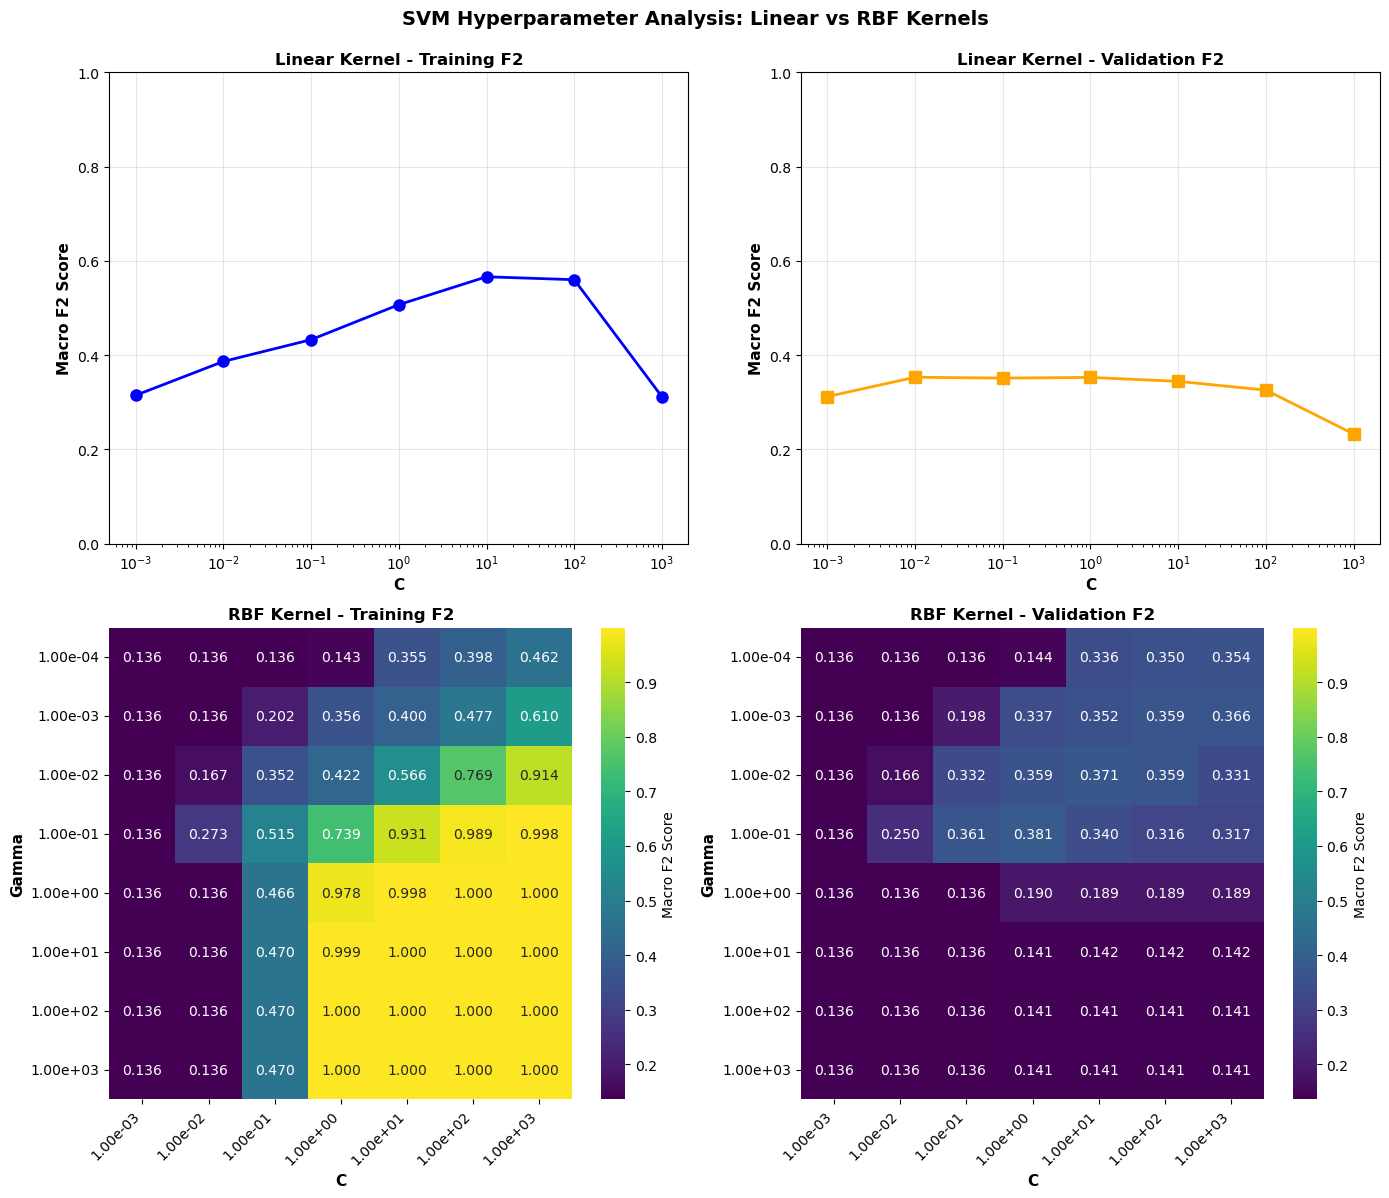

In [2]:
# ============================================================================
# CREATE PLOTS
# ============================================================================

print(f"\n{'='*80}")
print("CREATING PLOTS")
print(f"{'='*80}")

# Aggregate tuning results
all_tune_data = []
for result in all_results:
    for tune_result in result['tune_results']:
        all_tune_data.append(tune_result)

tune_df = pd.DataFrame(all_tune_data)

# Separate linear and RBF BEFORE grouping
linear_df = tune_df[tune_df['kernel'] == 'linear'].copy()
rbf_df = tune_df[tune_df['kernel'] == 'rbf'].copy()

# Group separately (linear doesn't need gamma in groupby)
linear_summary = linear_df.groupby(['C']).agg({
    'train_f2': 'mean',
    'val_f2': 'mean',
}).reset_index()

rbf_summary = rbf_df.groupby(['C', 'gamma']).agg({
    'train_f2': 'mean',
    'val_f2': 'mean',
}).reset_index()

print(f"\nLinear summary shape: {linear_summary.shape}")
print(f"Linear summary:\n{linear_summary}")
print(f"\nRBF summary shape: {rbf_summary.shape}")

# Create 2x2 subplot: Linear (train/val) and RBF (train/val)
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# ============================================================================
# LINEAR KERNEL PLOTS (C only)
# ============================================================================

# Plot 1: Linear - Training F2
ax1 = axes[0, 0]
ax1.plot(linear_summary['C'], linear_summary['train_f2'], 'o-', linewidth=2, markersize=8, color='blue')
ax1.set_xscale('log')
ax1.set_ylim([0, 1])  # Fix y-axis range
ax1.set_xlabel('C', fontsize=11, fontweight='bold')
ax1.set_ylabel('Macro F2 Score', fontsize=11, fontweight='bold')
ax1.set_title('Linear Kernel - Training F2', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot 2: Linear - Validation F2
ax2 = axes[0, 1]
ax2.plot(linear_summary['C'], linear_summary['val_f2'], 's-', linewidth=2, markersize=8, color='orange')
ax2.set_xscale('log')
ax2.set_ylim([0, 1])  # Fix y-axis range
ax2.set_xlabel('C', fontsize=11, fontweight='bold')
ax2.set_ylabel('Macro F2 Score', fontsize=11, fontweight='bold')
ax2.set_title('Linear Kernel - Validation F2', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# ============================================================================
# RBF KERNEL HEATMAPS (C vs gamma)
# ============================================================================

# Create pivot tables for RBF
rbf_train_pivot = rbf_summary.pivot(index='gamma', columns='C', values='train_f2')
rbf_val_pivot = rbf_summary.pivot(index='gamma', columns='C', values='val_f2')

# Determine common color scale
vmin = min(rbf_train_pivot.min().min(), rbf_val_pivot.min().min())
vmax = max(rbf_train_pivot.max().max(), rbf_val_pivot.max().max())

# Plot 3: RBF - Training F2
ax3 = axes[1, 0]
sns.heatmap(rbf_train_pivot, ax=ax3, cmap='viridis', vmin=vmin, vmax=vmax,
            annot=True, fmt='.3f', cbar_kws={'label': 'Macro F2 Score'})
ax3.set_title('RBF Kernel - Training F2', fontsize=12, fontweight='bold')
ax3.set_xlabel('C', fontsize=11, fontweight='bold')
ax3.set_ylabel('Gamma', fontsize=11, fontweight='bold')
ax3.set_xticklabels([f'{x:.2e}' for x in rbf_train_pivot.columns], rotation=45, ha='right')
ax3.set_yticklabels([f'{y:.2e}' for y in rbf_train_pivot.index], rotation=0)

# Plot 4: RBF - Validation F2
ax4 = axes[1, 1]
sns.heatmap(rbf_val_pivot, ax=ax4, cmap='viridis', vmin=vmin, vmax=vmax,
            annot=True, fmt='.3f', cbar_kws={'label': 'Macro F2 Score'})
ax4.set_title('RBF Kernel - Validation F2', fontsize=12, fontweight='bold')
ax4.set_xlabel('C', fontsize=11, fontweight='bold')
ax4.set_ylabel('Gamma', fontsize=11, fontweight='bold')
ax4.set_xticklabels([f'{x:.2e}' for x in rbf_val_pivot.columns], rotation=45, ha='right')
ax4.set_yticklabels([f'{y:.2e}' for y in rbf_val_pivot.index], rotation=0)

plt.suptitle('SVM Hyperparameter Analysis: Linear vs RBF Kernels', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../figures/hyperparameter_plots_svm.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: hyperparameter_plots_svm.png")

In [7]:
linear_summary

,C,train_f2,val_f2
0,0.001,0.314560,0.311889
1,0.010,0.386423,0.352949
2,0.100,0.432713,0.351154
3,1.000,0.506927,0.352625
4,10.000,0.566185,0.344244
5,100.000,0.559966,0.325687
6,1000.000,0.311509,0.232504


In [8]:
# ============================
# BEST LINEAR MODEL (by val F2)
# ============================

best_linear_row = linear_summary.loc[linear_summary['val_f2'].idxmax()]

best_linear_C = best_linear_row['C']
best_linear_val_f2 = best_linear_row['val_f2']
best_linear_train_f2 = best_linear_row['train_f2']

print("\nBest Linear Kernel (by avg validation F2):")
print(best_linear_row)


Best Linear Kernel (by avg validation F2):
C           0.010000
train_f2    0.386423
val_f2      0.352949
Name: 1, dtype: float64


In [9]:
rbf_summary

,C,gamma,train_f2,val_f2
0,0.001,0.0001,0.136467,0.136443
1,0.001,0.0010,0.136467,0.136443
2,0.001,0.0100,0.136467,0.136443
3,0.001,0.1000,0.136467,0.136443
4,0.001,1.0000,0.136467,0.136443
5,0.001,10.0000,0.136467,0.136443
6,0.001,100.0000,0.136467,0.136443
7,0.001,1000.0000,0.136467,0.136443
8,0.010,0.0001,0.136467,0.136443
9,0.010,0.0010,0.136467,0.136443


In [10]:
# ============================
# BEST RBF MODEL (by val F2)
# ============================

best_rbf_row = rbf_summary.loc[rbf_summary['val_f2'].idxmax()]

best_rbf_C = best_rbf_row['C']
best_rbf_gamma = best_rbf_row['gamma']
best_rbf_val_f2 = best_rbf_row['val_f2']
best_rbf_train_f2 = best_rbf_row['train_f2']

print("\nBest RBF Kernel (by avg validation F2):")
print(best_rbf_row)



Best RBF Kernel (by avg validation F2):
C           1.000000
gamma       0.100000
train_f2    0.739069
val_f2      0.381103
Name: 27, dtype: float64


In [11]:
# ============================================================================
# SAVE RESULTS
# ============================================================================

print(f"\n{'='*80}")
print("SAVING RESULTS")
print(f"{'='*80}")

final_results = {
    'all_results': all_results,
    'config': {
        'model': 'SVM',
        'random_states': RANDOM_STATES,
        'C_values': C_VALUES.tolist(),
        'gamma_values': GAMMA_VALUES.tolist(),
        'kernels': KERNELS,
    },
    'test_scores': {
        'mean': np.mean(test_f2_scores),
        'std': np.std(test_f2_scores),
        'all': test_f2_scores,
    },
    'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

output_file = '../results/pipeline_results_svm.pkl'
with open(output_file, 'wb') as f:
    pickle.dump(final_results, f)

print(f"\n✓ Saved to: {output_file}")
print(f"\nSaved components:")
print(f"  • 5 best models (one per random state)")
print(f"  • All data splits (original and preprocessed)")
print(f"  • Feature names")
print(f"  • All predictions (for confusion matrix)")
print(f"  • Hyperparameter tuning results")
print(f"  • Class weights")
print(f"  • Preprocessor objects")

print(f"\n{'='*80}")
print("PIPELINE COMPLETE!")
print(f"{'='*80}")


SAVING RESULTS

✓ Saved to: pipeline_results_svm.pkl

Saved components:
  • 5 best models (one per random state)
  • All data splits (original and preprocessed)
  • Feature names
  • All predictions (for confusion matrix)
  • Hyperparameter tuning results
  • Class weights
  • Preprocessor objects

PIPELINE COMPLETE!


In [2]:
import pickle
import pandas as pd
import numpy as np

# ============================================================================
# LOAD SAVED SVM RESULTS
# ============================================================================
output_file = '../results/pipeline_results_svm.pkl'

with open(output_file, 'rb') as f:
    final_results = pickle.load(f)

all_results = final_results['all_results']

# ============================================================================
# BUILD TUNING SUMMARY ACROSS RANDOM STATES
# ============================================================================
rows = []

for res in all_results:
    rs = res['random_state']
    for tr in res['tune_results']:
        rows.append({
            'random_state': rs,
            'kernel': tr['kernel'],
            'C': tr['C'],
            # gamma may not be used for all kernels; default to None
            'gamma': tr.get('gamma', None),
            'val_f2': tr['val_f2'],
        })

tune_df = pd.DataFrame(rows)

# Aggregate: mean & std of val_f2 for each (kernel, C, gamma)
tune_summary = (
    tune_df
    .groupby(['kernel', 'C', 'gamma'], as_index=False)
    .agg(
        mean_val_f2=('val_f2', 'mean'),
        std_val_f2=('val_f2', 'std'),
        n_runs=('val_f2', 'size')
    )
)

# ============================================================================
# FIND BEST HYPERPARAMETERS (BY MEAN VAL F2 ACROSS RUNS)
# ============================================================================
best_row = tune_summary.loc[tune_summary['mean_val_f2'].idxmax()]

print("Best SVM hyperparameters (by mean validation F2 across runs):")
print(f"  kernel   : {best_row['kernel']}")
print(f"  C        : {best_row['C']}")
print(f"  gamma    : {best_row['gamma']}")
print(f"  Mean Val F2 : {best_row['mean_val_f2']:.4f}")
print(f"  Std  Val F2 : {best_row['std_val_f2']:.4f}")
print(f"  Runs used   : {int(best_row['n_runs'])}")

print(
    f"\nValidation F2 (mean ± std): "
    f"{best_row['mean_val_f2']:.4f} ± {best_row['std_val_f2']:.4f}"
)


Best SVM hyperparameters (by mean validation F2 across runs):
  kernel   : rbf
  C        : 1.0
  gamma    : 0.1
  Mean Val F2 : 0.3811
  Std  Val F2 : 0.0175
  Runs used   : 5

Validation F2 (mean ± std): 0.3811 ± 0.0175
